# Imports

In [1]:
import pathlib

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
# another slighly odd dependency
import lmfit

fig_dir = pathlib.Path("figures")
data_dir = pathlib.Path("data")

file_format = 'nc'

# Matplotlib stylesheet

In [2]:
plt.style.use('physrev.mplstyle')

# Load dataset from CSV

We have to manually extract the calibration points according to our schema

In [3]:
if file_format == 'csv':
    dataframe = pd.read_csv(data_dir / 'P_one_vs_time.csv')
    
    csv_signal = dataframe["U [V]"].to_numpy()
    csv_time = dataframe["time [us]"].to_numpy()

    # determine number of callibration points from nan time count
    n_calib_total = np.sum(np.isnan(csv_time))
    assert n_calib_total % 2 == 0
    n_calib = n_calib_total // 2
    assert n_calib
    
    raw_signal = csv_signal[:-n_calib_total]
    times = csv_time[:-n_calib_total]
    cal_one = csv_signal[-n_calib:]
    cal_zero = csv_signal[-n_calib_total:-n_calib]

    print(dataframe)
    
    assert np.all(np.isfinite(times))

# Load data from netCDF

In [5]:
if file_format == 'nc':
    dataset = xr.load_dataset(data_dir / 'P_one_vs_time.nc')

    nc_times = dataset['time [us]']
    nc_signal = dataset['U [V]']
    cal_one = nc_signal.attrs['calib_1 [V]']
    cal_zero = nc_signal.attrs['calib_0 [V]']

    # the rest of the code requires plain numpy arrays
    raw_signal = nc_signal.to_numpy()
    times = nc_times.to_numpy()
    
    print(dataset)
    print(dataset.attrs)

<xarray.Dataset>
Dimensions:    (time [us]: 250)
Coordinates:
  * time [us]  (time [us]) float64 0.0 0.1004 0.2008 0.3012 ... 24.8 24.9 25.0
Data variables:
    U [V]      (time [us]) float64 0.7061 0.6714 0.6847 ... 0.488 0.5096 0.4282
Attributes:
    comment:  Ramsey T2* experiment. Each voltage curve has callibration meas...
{'comment': 'Ramsey T2* experiment. Each voltage curve has callibration measurements for 0 and 1 probability.'}


# Callibrate

In [6]:
offset = np.mean(cal_zero)
scale = np.mean(cal_one) - offset

P_one = (raw_signal-offset)/scale

# Fit dataset with lmfit

This would transparently show the data analysis such that people can see you did your fits correctly

In [7]:
def exp_damp_osc_func(
    t: float,
    tau: float,
    n_factor: float,
    frequency: float,
    phase: float,
    amplitude: float,
    offset: float,
):
    r"""
    A sinusoidal oscillation with an exponentially decaying envelope function:

    :math:`y = \mathrm{amplitude} \times \exp\left(-(t/\tau)^\mathrm{n\_factor}\right)(\cos(2\pi\mathrm{frequency}\times t + \mathrm{phase}) + \mathrm{oscillation_offset}) + \mathrm{exponential_offset}`

    Parameters
    ----------
    t:
        time
    tau:
        decay time
    n_factor:
        exponential decay factor
    frequency:
        frequency of the oscillation
    phase:
        phase of the oscillation
    amplitude:
        initial amplitude of the oscillation
    oscillation_offset:
        vertical offset of cosine oscillation relative to exponential asymptote
    exponential_offset:
        offset of exponential asymptote

    Returns
    -------
    :
        Output of decaying cosine function as a float
    """  
    
    oscillation = amplitude * (np.cos(2 * np.pi * frequency * t + phase))
    exp_decay = np.exp(-((t / tau) ** n_factor))
    osc_decay = oscillation * exp_decay + offset
    return osc_decay

def fft_freq_phase_guess(data: np.ndarray, t: np.ndarray):
    """
    Guess for a cosine fit using FFT, only works for evenly spaced points.

    Parameters
    ----------
    data:
        Input data to FFT
    t:
        Independent variable (e.g. time)

    Returns
    -------
    freq_guess:
        Guess for the frequency of the cosine function
    ph_guess:
        Guess for the phase of the cosine function
    """

    # Only first half of array is used, because the second half contains the
    # negative frequecy components, and we want a positive frequency.
    power = np.fft.fft(data)[: len(data) // 2]
    freq = np.fft.fftfreq(len(data), t[1] - t[0])[: len(power)]
    power[0] = 0  # Removes DC component from fourier transform

    # Use absolute value of complex valued spectrum
    abs_power = np.abs(power)
    freq_guess = abs(freq[abs_power == max(abs_power)][0])
    # the condition data == max(data) can have several solutions
    #               (for example when discretization is visible)
    # to prevent errors we pick the first solution
    ph_guess = 2 * np.pi - (2 * np.pi * t[data == max(data)] * freq_guess)[0]

    return freq_guess, ph_guess

class DecayOscillationModel(lmfit.model.Model):
    r"""
    Model for a decaying oscillation which decays to a point with 0 offset from
    the centre of the of the oscillation (as in a Ramsey experiment, for example).
    """

    def __init__(self, *args, **kwargs):
        # pass in the defining equation so the user doesn't have to later.
        super().__init__(exp_damp_osc_func, *args, **kwargs)

        # Enforce oscillation frequency is positive
        self.set_param_hint("frequency", min=0)
        # Enforce amplitude is positive
        self.set_param_hint("amplitude", min=0)
        # Enforce decay time is positive
        self.set_param_hint("tau", min=0)

        # Fix the n_factor at 1
        self.set_param_hint("n_factor", expr="1", vary=False)

    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        t = kws.get("t", None)
        if t is None:
            raise ValueError(
                'Time variable "t" must be specified in order to guess parameters'
            )
            return None

        amp_guess = abs(max(data) - min(data)) / 2  # amp is positive by convention
        exp_offs_guess = np.mean(data)
        tau_guess = 2 / 3 * np.max(t)

        (freq_guess, phase_guess) = fft_freq_phase_guess(data, t)

        self.set_param_hint("frequency", value=freq_guess, min=0)
        self.set_param_hint("amplitude", value=amp_guess, min=0)
        self.set_param_hint("offset", value=exp_offs_guess)
        self.set_param_hint("phase", value=phase_guess)
        self.set_param_hint("tau", value=tau_guess, min=0)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)



In [8]:
model = DecayOscillationModel()

guess_pars = model.guess(P_one, t=times)

fit_result = model.fit(P_one, params=guess_pars, t=times)

In [9]:
print(fit_result.fit_report())

[[Model]]
    Model(exp_damp_osc_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 250
    # variables        = 5
    chi-square         = 0.35853448
    reduced chi-square = 0.00146341
    Akaike info crit   = -1626.79784
    Bayesian info crit = -1609.19054
    R-squared          = 0.90215370
[[Variables]]
    tau:        5.01779305 +/- 0.21169996 (4.22%) (init = 16.66667)
    n_factor:   1.00000000 +/- 0.00000000 (0.00%) == '1'
    frequency:  0.39858599 +/- 0.00140554 (0.35%) (init = 0.3984)
    phase:      6.21492286 +/- 0.03177754 (0.51%) (init = 6.283185)
    amplitude:  0.50044153 +/- 0.01457583 (2.91%) (init = 0.4519575)
    offset:     0.49897142 +/- 0.00243248 (0.49%) (init = 0.5011251)
[[Correlations]] (unreported correlations are < 0.100)
    C(frequency, phase) = -0.7228
    C(tau, amplitude)   = -0.6876
    C(phase, amplitude) = +0.1345


# Create Figure 1

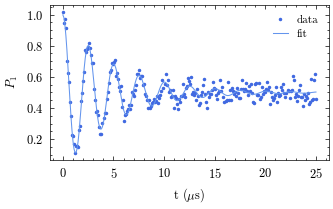

In [10]:


fig, ax = plt.subplots(figsize=(3.375, 2))

ax.plot(times, P_one, ".", label="data", markersize=3, color="royalblue")
ax.plot(times, fit_result.best_fit, "-", label="fit", color="cornflowerblue")

plt.legend(frameon=False)
plt.xlabel(r't ($\mathrm{\mu}$s)')
plt.ylabel('$P_1$')

fig_dir.mkdir(exist_ok=True)
plt.savefig(fig_dir / "fig1.pdf")